# Projet 6

In [1]:
# Importation des librairies
import sys # Python v3.12.4
import os
import re
import string
import pandas as pd # v2.2.3
import numpy as np # v2.0.2
import matplotlib # v3.9.2
import matplotlib.pyplot as plt
import seaborn as sns # v0.13.2
import plotly # v5.24.1
import plotly.express as px
import cv2 # v4.10.0
import time
import tensorflow as tf # v2.18.0

from os import listdir
from IPython.display import Image, display, HTML
from PIL import Image
from matplotlib.image import imread
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, adjusted_rand_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, Model, Sequential, applications, layers, preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.layers import RandomFlip, Dense, Dropout, RandomRotation, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19, decode_predictions, preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input




In [2]:
# Information sur l'environnement virtuel :
print("Version des librairies :")
print("Python        : " + sys.version)
print("Pandas        : " + pd.__version__)
print("NumPy         : " + np.version.__version__)
print("Matplotlib    : " + matplotlib.__version__)
print("Seaborn       : " + sns.__version__)
print("plotly        : " + plotly.__version__)
print("cv2           : " + cv2.__version__)
print("TensorFlow    : " + tf.__version__)

Version des librairies :
Python        : 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
Pandas        : 2.2.3
NumPy         : 2.0.2
Matplotlib    : 3.9.2
Seaborn       : 0.13.2
plotly        : 5.24.1
cv2           : 4.10.0
TensorFlow    : 2.18.0


In [3]:
# Paramètre d'affichage :
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

# style de titres
style = {"family": "Arial",
        "color":  'darkblue',
        "weight": "bold",
        "size": 15,
        }

## Fonction Utilitaires

In [4]:
def clean_text(text):
    text = str(text).lower()  # Convertit en minuscule
    text = re.sub(r'\d+|\[.*?\]|https?://\S+|www\.\S+', '', text)  # Supprime chiffres, balises HTML et URL
    text = re.sub(r'['
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symboles et pictogrammes
                u"\U0001F680-\U0001F6FF"  # symboles de transport et de carte
                u"\U0001F1E0-\U0001F1FF"  # drapeaux (iOS)
                u"\u200d"                 # jointure à largeur zéro
                u"\u2640-\u2642"          # Symboles de genre
                u"\U000024C2-\U0001F251"  # Caractères enfermés
                ']+', '', text)  # Supprime emojis et symboles
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Supprime la ponctuation
    return text

def resize_large_image(file_path, max_size=(1024, 1024)):
    try:
        with Image.open(file_path) as img:
            if img.size[0] > max_size[0] or img.size[1] > max_size[1]:
                img = img.resize(max_size, Image.Resampling.LANCZOS)  # Utilisation de LANCZOS
                img.save(file_path)
    except Exception as e:
        print(f"Erreur lors du redimensionnement de {file_path}: {e}")

def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return True
    except:
        return False

def create_tf_dataset(dataframe, x_col, y_col, batch_size=32, img_size=(224, 224)):
    def process_image(file_path, label):
        # Chargement et redimensionnement de l'image
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size)
        image = preprocess_input(image)  # Normalisation
        label = tf.one_hot(label, depth=7)  # Encodage des labels en one-hot (7 classes)
        return image, label

    # Conversion en Dataset TensorFlow
    file_paths = dataframe[x_col].values
    labels = dataframe[y_col].astype(int).values
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(dataframe)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

<u>Méthode  | Qualité    | Vitesse     | Applications</u>    
* NEAREST  | Faible     | Très rapide | Simple, rendu rapide.    
* BILINEAR | Moyenne    | Rapide      | Bonne pour un usage général.    
* BICUBIC  | Bonne      | Moyenne     | Agrandissements et réductions.    
* LANCZOS  | Très bonne | Plus lente  | Réductions avec haute fidélité.

# Importation des données

In [5]:
data = pd.read_csv("data_image.csv")

data_image = data[["image", "cat_label"]]

path = "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv6/Images"

list_photos = [file for file in listdir(path)]
print(len(list_photos))

data_image.loc[:, "image"] = data_image["image"].apply(lambda x: os.path.join(path, str(x)))

1050


In [6]:
label = ["0", "1", "2", "3", "4", "5", "6"]
for i in range(len(label)):
    data_verif = data.loc[data["cat_label"] == i]
    cat = data_verif["cat_niv_1"].iloc[0]
    cat_cleaned = re.sub(r'["\[\]]', '', cat)
    print("Le label numéro {} correspond à la catégorie : {}".format(i, cat_cleaned))

Le label numéro 0 correspond à la catégorie : Baby Care
Le label numéro 1 correspond à la catégorie : Beauty and Personal Care
Le label numéro 2 correspond à la catégorie : Computers
Le label numéro 3 correspond à la catégorie : Home Decor & Festive Needs
Le label numéro 4 correspond à la catégorie : Home Furnishing
Le label numéro 5 correspond à la catégorie : Kitchen & Dining
Le label numéro 6 correspond à la catégorie : Watches


In [7]:
# Augmentation de données
datagen = ImageDataGenerator(
                            preprocessing_function=preprocess_input,
                            rotation_range=30,        # Rotation des images
                            width_shift_range=0.2,    # Décalage Horizontale
                            height_shift_range=0.2,   # Décalage en hauteur
                            shear_range=0.15,         # Radians
                            zoom_range=0.2,           # Zoom
                            horizontal_flip=True)     # Probabilité (50%) de retournement horizontale de l'image

In [8]:
# Sélectionner les caractéristiques et les étiquettes
X = data_image["image"]
y = data_image["cat_label"].astype(str)

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

# Diviser l'ensemble de test en ensembles de test et de validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.25, random_state=77)

In [9]:
# Création du Early Stop
early_stop = EarlyStopping(monitor="val_loss",patience=3)

# Nombre d'itérations d'entraînement
epochs = 15

# Modélisation

In [10]:
# Vérifier la distribution des classes
print("Distribution des classes dans l'ensemble d'entraînement :")
print(y_train.value_counts())

print("Distribution des classes dans l'ensemble de validation :")
print(y_val.value_counts())

# Calculer les poids de classe
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 1.0,
    6: 1.0
}
print("Poids de classe :", class_weight_dict)

Distribution des classes dans l'ensemble d'entraînement :
cat_label
0    126
6    124
4    121
1    120
3    119
2    118
5    112
Name: count, dtype: int64
Distribution des classes dans l'ensemble de validation :
cat_label
5    12
1    10
2     8
4     7
3     7
0     6
6     3
Name: count, dtype: int64
Poids de classe : {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}


# MobileNetV2

In [11]:
"""# Augmentation de la limite des pixels autorisés
Image.MAX_IMAGE_PIXELS = None

# Restructuration du Répertoire des images
path = "C:\\Users\\icema\\OpenClassrooms\\AI_Engineer\\.venv6\\Images"

# Lister tous les fichiers au format jpg
image_files = [os.path.join(path, file) for file in os.listdir(path) if file.lower().endswith('.jpg')]
print(f"Nombre d'images détectées : {len(image_files)}")

# Création d'un DataFrame avec les chemins d'image
data_image = pd.DataFrame({"image": image_files})

# Chargement des étiquettes
data_original = pd.read_csv("data_image.csv")
data_original["image"] = data_original["image"].apply(lambda x: os.path.join(path, str(x)))

# Fusionner les étiquettes
data_image = data_image.merge(data_original[["image", "cat_label"]], on="image", how="inner")
print(f"Nombre d'images après fusion : {len(data_image)}")

# Redimensionner toutes les images si besoin
for image_path in data_image["image"]:
    resize_large_image(image_path)

data_image = data_image[data_image["image"].apply(is_valid_image)]
print(f"Nombre d'images valides après vérification : {len(data_image)}")

# Diviser les données avec stratification
X = data_image["image"]
y = data_image["cat_label"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.25, random_state=77, stratify=y_test)

# Créeation des DataFrames
df_train = pd.DataFrame({"image": X_train, "cat_label": y_train})
df_test = pd.DataFrame({"image": X_test, "cat_label": y_test})
df_val = pd.DataFrame({"image": X_val, "cat_label": y_val})

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Générateurs
train_generator = datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col="image",
    y_col="cat_label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col="image",
    y_col="cat_label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col="image",
    y_col="cat_label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# Vérification du modèle
model = Sequential([
    MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dense(7, activation="softmax")  # Nombre de classes = 7
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Entraînement
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)"""

'# Augmentation de la limite des pixels autorisés\nImage.MAX_IMAGE_PIXELS = None\n\n# Restructuration du Répertoire des images\npath = "C:\\Users\\icema\\OpenClassrooms\\AI_Engineer\\.venv6\\Images"\n\n# Lister tous les fichiers au format jpg\nimage_files = [os.path.join(path, file) for file in os.listdir(path) if file.lower().endswith(\'.jpg\')]\nprint(f"Nombre d\'images détectées : {len(image_files)}")\n\n# Création d\'un DataFrame avec les chemins d\'image\ndata_image = pd.DataFrame({"image": image_files})\n\n# Chargement des étiquettes\ndata_original = pd.read_csv("data_image.csv")\ndata_original["image"] = data_original["image"].apply(lambda x: os.path.join(path, str(x)))\n\n# Fusionner les étiquettes\ndata_image = data_image.merge(data_original[["image", "cat_label"]], on="image", how="inner")\nprint(f"Nombre d\'images après fusion : {len(data_image)}")\n\n# Redimensionner toutes les images si besoin\nfor image_path in data_image["image"]:\n    resize_large_image(image_path)\n\nd

Forme des images : (32, 224, 224, 3)
Forme des labels : (32, 7)
Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 603ms/step - accuracy: 0.3348 - loss: 1.8791 - val_accuracy: 0.6981 - val_loss: 0.9068
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 563ms/step - accuracy: 0.7604 - loss: 0.7755 - val_accuracy: 0.7358 - val_loss: 0.7489
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 561ms/step - accuracy: 0.8507 - loss: 0.4944 - val_accuracy: 0.7736 - val_loss: 0.6834
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 563ms/step - accuracy: 0.9199 - loss: 0.2929 - val_accuracy: 0.7736 - val_loss: 0.7389
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 564ms/step - accuracy: 0.9675 - loss: 0.1521 - val_accuracy: 0.8113 - val_loss: 0.6427
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 567ms/step - accuracy: 0.9736 - loss: 0.1075 - val_accuracy: 0.8679 - val_loss: 0.5887
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 566ms/step - accuracy: 0.9808 - loss: 0.0707 - val_accuracy: 0.8302 - val_loss: 0.6232
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━

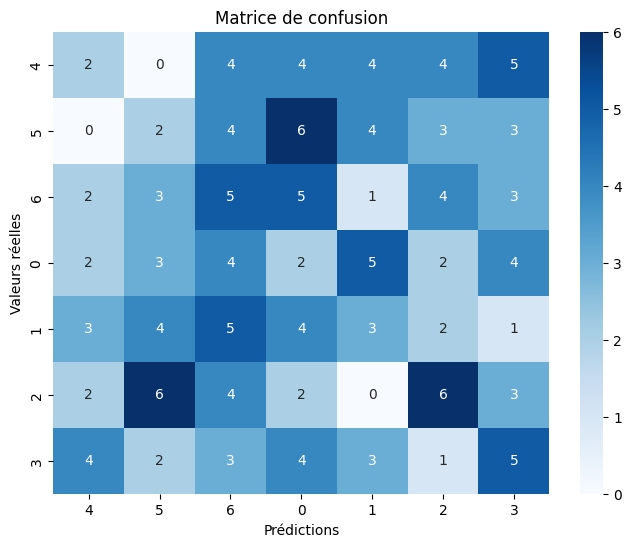

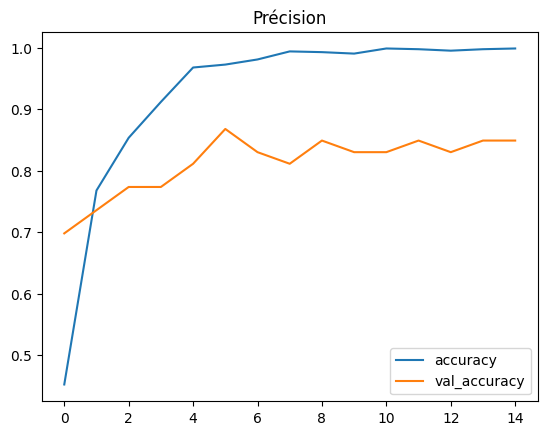

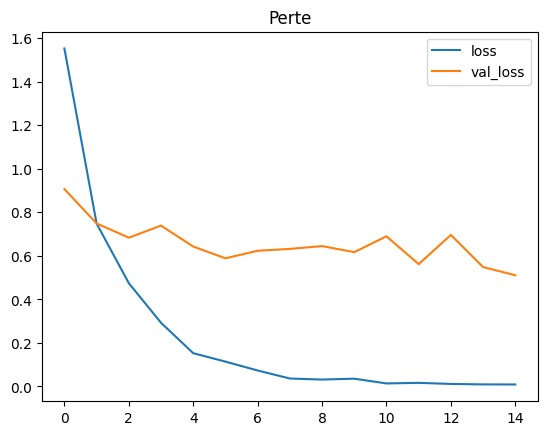

Rapport de classification :
              precision    recall  f1-score   support

           4       0.13      0.09      0.11        23
           5       0.10      0.09      0.10        22
           6       0.17      0.22      0.19        23
           0       0.07      0.09      0.08        22
           1       0.15      0.14      0.14        22
           2       0.27      0.26      0.27        23
           3       0.21      0.23      0.22        22

    accuracy                           0.16       157
   macro avg       0.16      0.16      0.16       157
weighted avg       0.16      0.16      0.16       157



In [12]:
# Chargement des données
path = "C:\\Users\\icema\\OpenClassrooms\\AI_Engineer\\.venv6\\Images"
data_original = pd.read_csv("data_image.csv")
data_original["image"] = data_original["image"].apply(lambda x: os.path.join(path, str(x)))

# Préparation des données
X = data_original["image"]
y = data_original["cat_label"].astype(str)

# Division des données en ensembles d'entraînement, de validation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.25, random_state=77, stratify=y_test)

# Création des DataFrames pour chaque ensemble
df_train = pd.DataFrame({"image": X_train, "cat_label": y_train})
df_test = pd.DataFrame({"image": X_test, "cat_label": y_test})
df_val = pd.DataFrame({"image": X_val, "cat_label": y_val})

# Création des datasets TensorFlow
train_dataset = create_tf_dataset(df_train, "image", "cat_label")
val_dataset = create_tf_dataset(df_val, "image", "cat_label")
test_dataset = create_tf_dataset(df_test, "image", "cat_label")

# Vérification des datasets
for images, labels in train_dataset.take(1):  # Vérifiez un lot d'entraînement
    print("Forme des images :", images.shape)
    print("Forme des labels :", labels.shape)

# Modélisation
model = Sequential([
    MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dense(7, activation="softmax")  # Nombre de classes = 7
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Entraînement
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15
)

# Évaluation sur l'ensemble de test
eval_results = model.evaluate(test_dataset)
print("Perte sur le test :", eval_results[0])
print("Exactitude sur le test :", eval_results[1])

# Étiquettes
y_true = []
for _, labels in test_dataset:
    y_true.extend(tf.argmax(labels, axis=1).numpy())
y_true = np.array(y_true)

# Prédictions sur le test
y_pred = model.predict(test_dataset)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

# Calcul de la matrice de confusion
class_names = list(df_test["cat_label"].unique())
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.show()

history_df = pd.DataFrame(history.history)
history_df[["accuracy", "val_accuracy"]].plot(title="Précision")
plt.show()
history_df[["loss", "val_loss"]].plot(title="Perte")
plt.show()

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [13]:
# Vérification d'un lot à partir de train_dataset
images, labels = next(iter(train_dataset))
print("Forme des images :", images.shape)
print("Forme des labels :", labels.shape)
print("Type des images :", images.dtype)
print("Type des labels :", labels.dtype)

# Vérification des valeurs min et max des images (normalisation)
print("Valeurs min et max des images :", images.numpy().min(), images.numpy().max())

Forme des images : (32, 224, 224, 3)
Forme des labels : (32, 7)
Type des images : <dtype: 'float32'>
Type des labels : <dtype: 'float32'>
Valeurs min et max des images : -1.0 1.0


# CNN Sequentiel

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,880,327 (7.17 MB)

 Trainable params: 1,880,327 (7.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.1556 - loss: 2.0640 - val_accuracy: 0.2075 - val_loss: 1.9106
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.2370 - loss: 1.9075 - val_accuracy: 0.3019 - val_loss: 1.8422
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.3583 - loss: 1.7205 - val_accuracy: 0.4340 - val_loss: 1.5529
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.4947 - loss: 1.4501 - val_accuracy: 0.4340 - val_loss: 1.5287
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.5371 - loss: 1.2894 - val_accuracy: 0.3208 - val_loss: 1.9312
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.6155 - loss: 1.0843 - val_accuracy: 0.4151 - val_loss: 1.7278
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.7406 - loss: 0.7990 - val_accuracy: 0.5283 - val_loss: 1.6834
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.7817 - loss: 0.6165 - val_accuracy: 0.

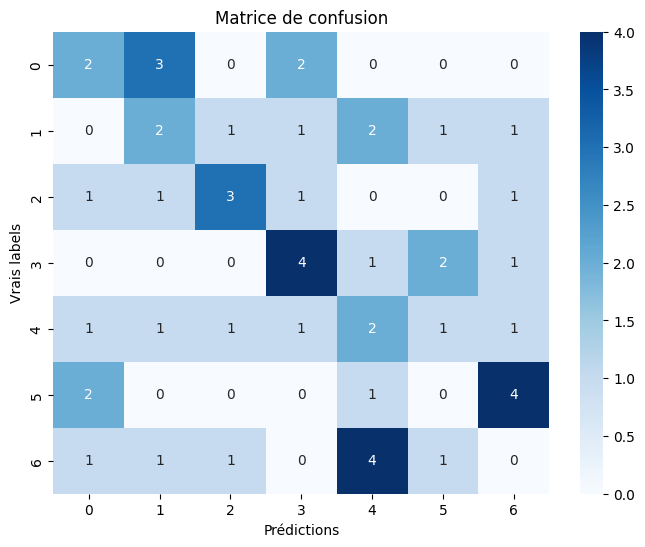

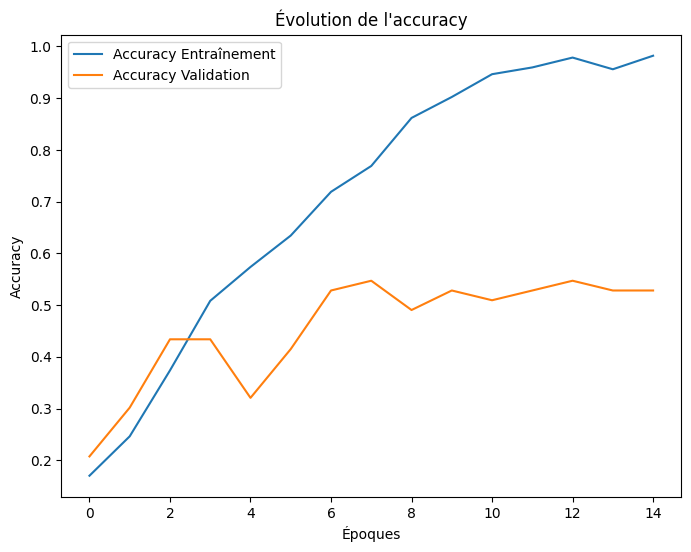

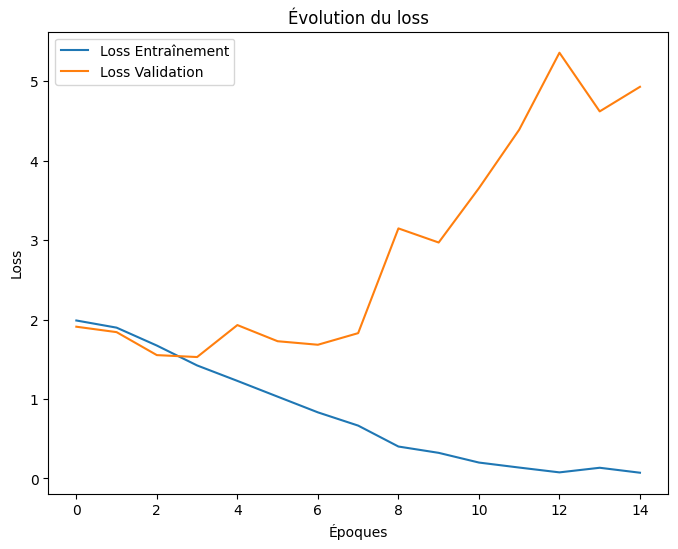

Temps d'exécution : 56.48653984069824 secondes
Rapport de classification :
              precision    recall  f1-score   support

           4       0.29      0.29      0.29         7
           5       0.25      0.25      0.25         8
           6       0.50      0.43      0.46         7
           0       0.44      0.50      0.47         8
           1       0.20      0.25      0.22         8
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         8

    accuracy                           0.25        53
   macro avg       0.24      0.24      0.24        53
weighted avg       0.24      0.25      0.24        53



In [14]:
start_time = time.time()

# Création du modèle
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(7, activation="softmax")  # 7 classes
])

# Compilation du modèle
model.compile(
    loss="categorical_crossentropy",
    optimizer=RMSprop(),
    metrics=["accuracy"]
)

# Résumé du modèle
model.summary()

# Entraînement du modèle
history_seq = model.fit(
    train_dataset,      # Jeu de données pour l'entraînement
    validation_data=val_dataset,  # Jeu de données pour la validation
    epochs=15
)

# Prédictions sur le jeu de validation
y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Récupération des vraies étiquettes depuis val_dataset
y_true = []
for images, labels in val_dataset:
    y_true.append(np.argmax(labels.numpy(), axis=1))
y_true = np.concatenate(y_true)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vrais labels")
plt.show()

# Évolution de l'accuracy (entraînement et validation)
plt.figure(figsize=(8, 6))
plt.plot(history_seq.history["accuracy"], label="Accuracy Entraînement")
plt.plot(history_seq.history["val_accuracy"], label="Accuracy Validation")
plt.title("Évolution de l'accuracy")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Évolution du loss (entraînement et validation)
plt.figure(figsize=(8, 6))
plt.plot(history_seq.history["loss"], label="Loss Entraînement")
plt.plot(history_seq.history["val_loss"], label="Loss Validation")
plt.title("Évolution du loss")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.show()

end_time = time.time()
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

print("Rapport de classification :")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# VGG19

In [15]:
"""start_time = time.time()

# Utilisation du modèle pré-entrainé VGG19
inputs = Input(shape=(224, 224, 3))
vgg_model = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
outputs = vgg_model.output

# Couches supplémentaires
x = MaxPooling2D(pool_size=(2, 2))(outputs)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(7, activation="softmax")(x)

# Construire le modèle complet
model = Model(inputs=inputs, outputs=predictions)

# Compiler le modèle
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Afficher un résumé du modèle
model.summary()

# Entraîner le modèle sur les données d'entraînement
history = model.fit(train_generator,
                    batch_size=32,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_batch_size=32,
                    callbacks=[early_stop])

end_time = time.time()
execution_time = end_time - start_time
print("Temps d'exécution : ", execution_time, " secondes")"""

'start_time = time.time()\n\n# Utilisation du modèle pré-entrainé VGG19\ninputs = Input(shape=(224, 224, 3))\nvgg_model = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)\noutputs = vgg_model.output\n\n# Couches supplémentaires\nx = MaxPooling2D(pool_size=(2, 2))(outputs)\nx = Flatten()(x)\nx = Dense(128, activation="relu")(x)\npredictions = Dense(7, activation="softmax")(x)\n\n# Construire le modèle complet\nmodel = Model(inputs=inputs, outputs=predictions)\n\n# Compiler le modèle\nmodel.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])\n\n# Afficher un résumé du modèle\nmodel.summary()\n\n# Entraîner le modèle sur les données d\'entraînement\nhistory = model.fit(train_generator,\n                    batch_size=32,\n                    epochs=epochs,\n                    validation_data=val_generator,\n                    validation_batch_size=32,\n                    callbacks=[early_stop])\n\nend_time = time.time()\nexecution_time = en

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       589,95

 Total params: 20,615,239 (78.64 MB)

 Trainable params: 20,615,239 (78.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.1300 - loss: 2.8582 - val_accuracy: 0.1321 - val_loss: 1.9527
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.1574 - loss: 1.9403 - val_accuracy: 0.1132 - val_loss: 1.9538
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.2305 - loss: 1.8857 - val_accuracy: 0.2453 - val_loss: 1.8842
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.2948 - loss: 1.8180 - val_accuracy: 0.2642 - val_loss: 1.8855
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.3518 - loss: 1.7614 - val_accuracy: 0.1509 - val_loss: 1.9639
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.3439 - loss: 1.7306 - val_accuracy: 0.3774 - val_loss: 1.6461
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.4206 - loss: 1.5871 - val_accuracy: 0.3585 - val_loss: 1.6281
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.4892 - loss: 1.3966 - val_accuracy: 0.5094 - val_loss:

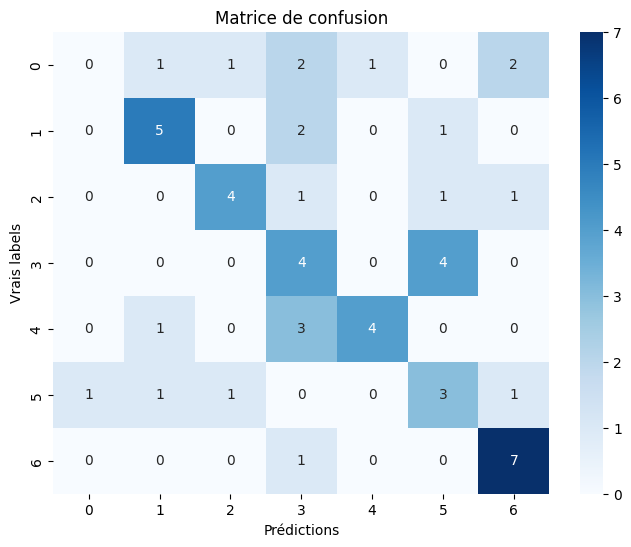

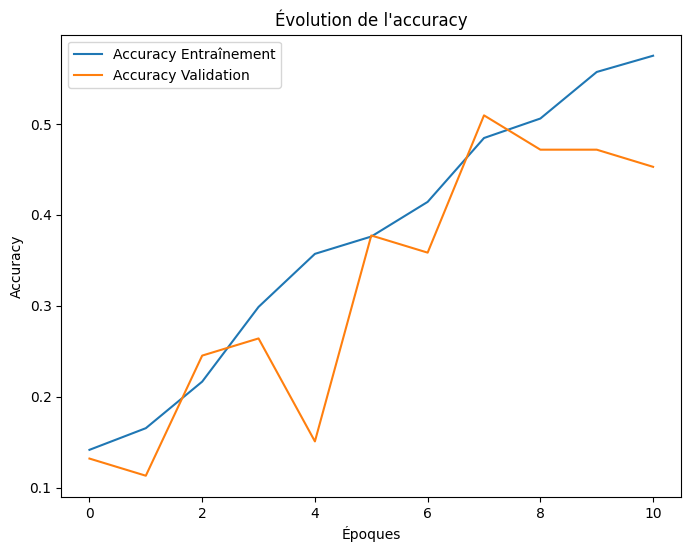

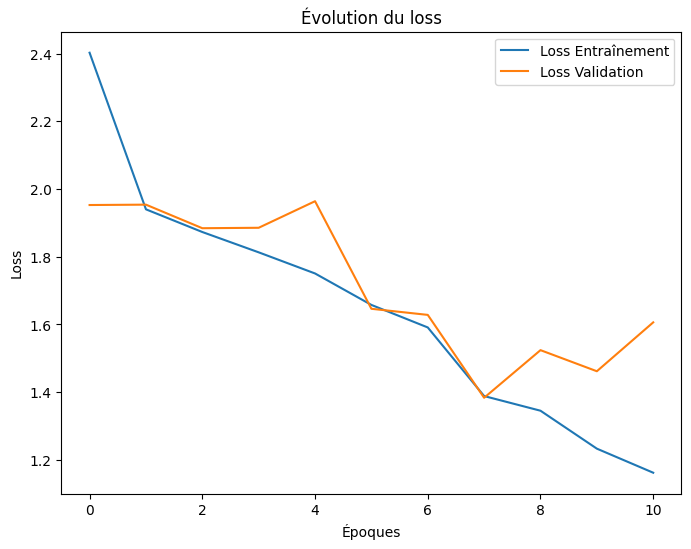

Temps d'exécution : 911.7307732105255 secondes
Rapport de classification :
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         7
           5       0.62      0.62      0.62         8
           6       0.67      0.57      0.62         7
           0       0.31      0.50      0.38         8
           1       0.80      0.50      0.62         8
           2       0.33      0.43      0.38         7
           3       0.64      0.88      0.74         8

    accuracy                           0.51        53
   macro avg       0.48      0.50      0.48        53
weighted avg       0.49      0.51      0.49        53



In [16]:
# Début de la mesure du temps
start_time = time.time()

# Configuration EarlyStopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Chargement du modèle pré-entraîné VGG19 sans la dernière couche (include_top=False)
inputs = Input(shape=(224, 224, 3))
vgg_model = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
outputs = vgg_model.output

# Couches supplémentaires pour affiner le modèle
x = MaxPooling2D(pool_size=(2, 2))(outputs)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(7, activation="softmax")(x)

# Construction du modèle
model = Model(inputs=inputs, outputs=predictions)

# Compilation du modèle
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Affichage du résumé du modèle
model.summary()

# Entraînement du modèle
history_vgg19 = model.fit(
    train_dataset,          # Jeu de données d'entraînement
    validation_data=val_dataset,  # Jeu de données de validation
    epochs=15,
    callbacks=[early_stop]
)

# ------------------------
# Conversion du dataset de validation en tenseurs (Pour corriger le warning due au retracing)
# ------------------------
X_val = []
Y_val = []
for images, labels in val_dataset:
    X_val.append(images)
    Y_val.append(labels)

# Concaténation des batches en un seul tenseur
X_val = tf.concat(X_val, axis=0)
Y_val = tf.concat(Y_val, axis=0)

# Récupération des vraies étiquettes
y_true = np.argmax(Y_val.numpy(), axis=1)

# Prédictions sur l'ensemble de validation
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vrais labels")
plt.show()

# Évolution de l'accuracy (entraînement et validation)
plt.figure(figsize=(8, 6))
plt.plot(history_vgg19.history["accuracy"], label="Accuracy Entraînement")
plt.plot(history_vgg19.history["val_accuracy"], label="Accuracy Validation")
plt.title("Évolution de l'accuracy")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Évolution du loss (entraînement et validation)
plt.figure(figsize=(8, 6))
plt.plot(history_vgg19.history["loss"], label="Loss Entraînement")
plt.plot(history_vgg19.history["val_loss"], label="Loss Validation")
plt.title("Évolution du loss")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Fin de la mesure du temps
end_time = time.time()
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_true, y_pred_classes, target_names=class_names, zero_division=0))

# RESNET50

In [17]:
"""start_time = time.time()

inputs = Input(shape=(224, 224, 3))
resnet_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
outputs = resnet_model.output

# Débloquer certaines couches pour le fine-tuning
for layer in resnet_model.layers:
    layer.trainable = False

# Ajout des couches personnalisées
x = GlobalAveragePooling2D()(outputs)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)  # Augmenter les neurones
x = Dropout(0.5)(x)  # Dropout pour régularisation
x = BatchNormalization()(x)  # Ajout de la normalisation
predictions = Dense(7, activation="softmax")(x)

model = Model(inputs=inputs, outputs=predictions)

# Compilation avec learning rate ajusté
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

# Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

# Entraînement
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

end_time = time.time()
execution_time = end_time - start_time
print("Temps d'exécution : ", execution_time, " secondes")"""

'start_time = time.time()\n\ninputs = Input(shape=(224, 224, 3))\nresnet_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)\noutputs = resnet_model.output\n\n# Débloquer certaines couches pour le fine-tuning\nfor layer in resnet_model.layers:\n    layer.trainable = False\n\n# Ajout des couches personnalisées\nx = GlobalAveragePooling2D()(outputs)\nx = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)  # Augmenter les neurones\nx = Dropout(0.5)(x)  # Dropout pour régularisation\nx = BatchNormalization()(x)  # Ajout de la normalisation\npredictions = Dense(7, activation="softmax")(x)\n\nmodel = Model(inputs=inputs, outputs=predictions)\n\n# Compilation avec learning rate ajusté\nmodel.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])\n\n# Callbacks\nearly_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)\nreduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patien

In [18]:
start_time = time.time()

# Définition du modèle basé sur ResNet50
inputs = Input(shape=(224, 224, 3))
resnet_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
outputs = resnet_model.output

# Débloquer certaines couches pour le fine-tuning
for layer in resnet_model.layers:
    layer.trainable = False  # Geler les couches pré-entraînées

# Ajout des couches personnalisées
x = GlobalAveragePooling2D()(outputs)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)  # Régularisation avec l2
x = Dropout(0.5)(x)  # Dropout pour éviter l'overfitting
x = BatchNormalization()(x)  # Normalisation pour stabiliser l'entraînement
predictions = Dense(7, activation="softmax")(x)  # Nombre de classes = 7

# Création du modèle final
model = Model(inputs=inputs, outputs=predictions)

# Compilation avec un learning rate ajusté
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

# Définition des callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

# Entraînement du modèle
history_res = model.fit(
    train_dataset,  # Dataset d'entraînement
    validation_data=val_dataset,  # Dataset de validation
    epochs=30,  # Nombre d'époques
    callbacks=[early_stop, reduce_lr]
)

end_time = time.time()
execution_time = end_time - start_time
print("Temps d'exécution : ", execution_time, " secondes")

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 346ms/step - accuracy: 0.1488 - loss: 6.8885 - val_accuracy: 0.1509 - val_loss: 6.3056 - learning_rate: 1.0000e-04
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 309ms/step - accuracy: 0.2220 - loss: 6.1941 - val_accuracy: 0.2075 - val_loss: 5.6431 - learning_rate: 1.0000e-04
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 309ms/step - accuracy: 0.3032 - loss: 5.6675 - val_accuracy: 0.3585 - val_loss: 5.1862 - learning_rate: 1.0000e-04
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - accuracy: 0.3623 - loss: 5.2374 - val_accuracy: 0.4528 - val_loss: 4.8359 - learning_rate: 1.0000e-04
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 312ms/step - accuracy: 0.3719 - loss: 4.8914 - val_accuracy: 0.5472 - val_loss: 4.5385 - learning_rate: 1.0000e-04
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step - accuracy: 0.3910 - loss: 4.5943 - val_accuracy: 0.5849 - val_loss: 4.2907 - learning_rate: 1.0000e-04
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step - accuracy:

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.1606 - loss: 6.7041 - val_accuracy: 0.3208 - val_loss: 6.0243 - learning_rate: 1.0000e-04
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - accuracy: 0.2736 - loss: 6.0558 - val_accuracy: 0.3774 - val_loss: 5.5435 - learning_rate: 1.0000e-04
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 307ms/step - accuracy: 0.3299 - loss: 5.5700 - val_accuracy: 0.3774 - val_loss: 5.1477 - learning_rate: 1.0000e-04
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - accuracy: 0.3317 - loss: 5.2159 - val_accuracy: 0.4717 - val_loss: 4.8234 - learning_rate: 1.0000e-04
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 307ms/step - accuracy: 0.4169 - loss: 4.8024 - val_accuracy: 0.5660 - val_loss: 4.5318 - learning_rate: 1.0000e-04
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - accuracy: 0.3809 - loss: 4.6006 - val_accuracy: 0.5660 - val_loss: 4.2876 - learning_rate: 1.0000e-04
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - accuracy:

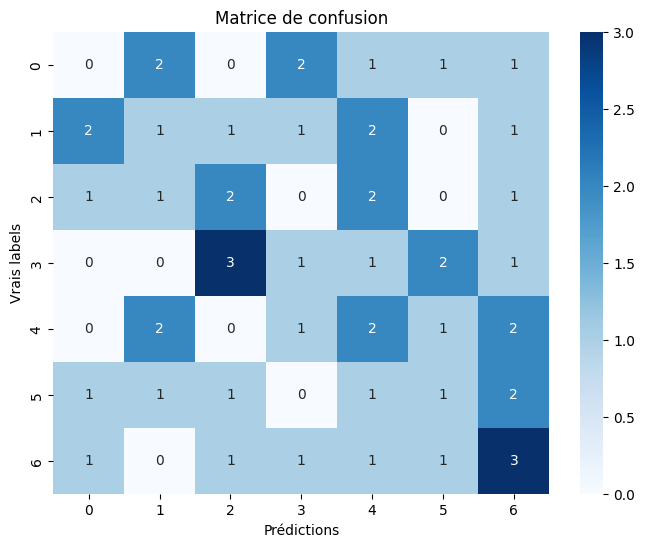

Rapport de classification :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.14      0.12      0.13         8
           2       0.25      0.29      0.27         7
           3       0.17      0.12      0.14         8
           4       0.20      0.25      0.22         8
           5       0.17      0.14      0.15         7
           6       0.27      0.38      0.32         8

    accuracy                           0.19        53
   macro avg       0.17      0.19      0.18        53
weighted avg       0.17      0.19      0.18        53



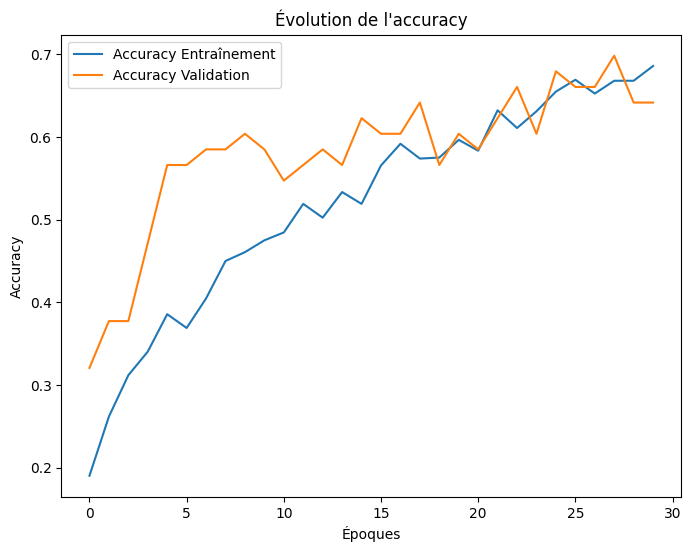

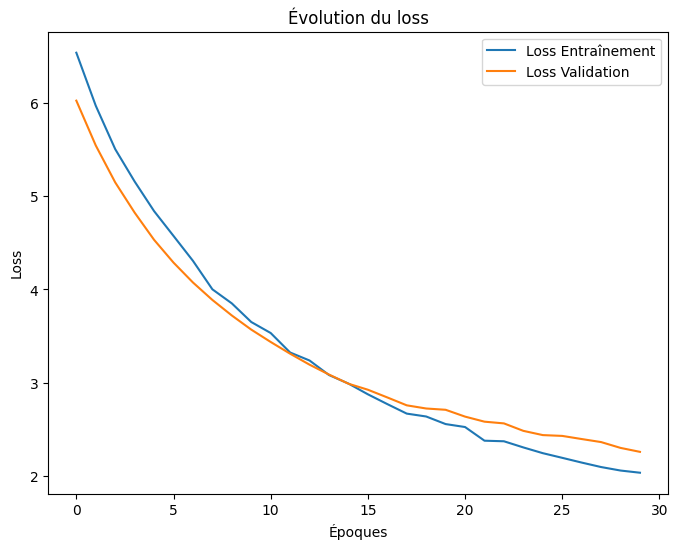

Temps d'exécution : 262.8561210632324 secondes


In [19]:
start_time = time.time()

# Chargement du modèle ResNet50 pré-entraîné
inputs = Input(shape=(224, 224, 3))
resnet_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
outputs = resnet_model.output

# Geler les couches de ResNet50
for layer in resnet_model.layers:
    layer.trainable = False

# Ajout de couches personnalisées
x = GlobalAveragePooling2D()(outputs)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(7, activation="softmax")(x)

# Construction du modèle final
model = Model(inputs=inputs, outputs=predictions)

# Compilation du modèle
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

# Définition des callbacks
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Entraînement du modèle
history_res = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

# Prédictions sur le jeu de validation
y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Récupération des étiquettes réelles depuis val_dataset
y_true = []
for images, labels in val_dataset:
    y_true.append(np.argmax(labels.numpy(), axis=1))
y_true = np.concatenate(y_true)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vrais labels")
plt.show()

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_true, y_pred_classes))

# Évolution de l'accuracy (entraînement et validation)
plt.figure(figsize=(8, 6))
plt.plot(history_res.history["accuracy"], label="Accuracy Entraînement")
plt.plot(history_res.history["val_accuracy"], label="Accuracy Validation")
plt.title("Évolution de l'accuracy")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Évolution du loss (entraînement et validation)
plt.figure(figsize=(8, 6))
plt.plot(history_res.history["loss"], label="Loss Entraînement")
plt.plot(history_res.history["val_loss"], label="Loss Validation")
plt.title("Évolution du loss")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.show()

end_time = time.time()
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

In [20]:
# Évaluation du modèle sur le dataset de validation
eval_results = model.evaluate(val_dataset)

# Afficher les résultats
print("Perte de validation :", eval_results[0])
print("Exactitude de validation :", eval_results[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.6256 - loss: 2.2956
Perte de validation : 2.2579524517059326
Exactitude de validation : 0.6415094137191772


In [21]:
print("Distribution des classes dans l'ensemble d'entraînement :")
print(y_train.value_counts())

print("Distribution des classes dans l'ensemble de validation :")
print(y_val.value_counts())

Distribution des classes dans l'ensemble d'entraînement :
cat_label
4    120
3    120
5    120
0    120
6    120
1    120
2    120
Name: count, dtype: int64
Distribution des classes dans l'ensemble de validation :
cat_label
4    8
1    8
3    8
6    8
5    7
2    7
0    7
Name: count, dtype: int64
